LAPS code:

In [1]:
import os
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

#from jax.lib import xla_bridge
#print(xla_bridge.get_backend().platform)
#print(jax.extend.backend.get_backend)

#os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(batch_size)
num_cores = jax.local_device_count()
print(num_cores)

import os, sys
sys.path.append('../../../blackjax/')

from blackjax.adaptation.laps import laps as run_laps



def laps(logdensity_fn, ndims, 
         sample_init, rng_key, 
         num_steps1, num_steps2, 
         num_chains, mesh):

    info, grads_per_step, _acc_prob, final_state = run_laps(    
        logdensity_fn=logdensity_fn, 
        sample_init= sample_init,
        ndims= ndims, 
        num_steps1=num_steps1, 
        num_steps2=num_steps2, 
        num_chains=num_chains, 
        mesh=mesh, 
        rng_key= rng_key, 
        early_stop= False,
        diagonal_preconditioning= True, 
        steps_per_sample=15,
        r_end=0.01,
        diagnostics= False,
        superchain_size= 1
        )

    return final_state.position


1


In [7]:
import functools
import jax.scipy.stats as stats


def regression_logprob(log_scale, coefs, preds, x):
        """Linear regression"""
        scale = jnp.exp(log_scale)
        scale_prior = stats.expon.logpdf(scale, 0, 1) + log_scale
        coefs_prior = stats.norm.logpdf(coefs, 0, 5)
        y = jnp.dot(x, coefs)
        logpdf = stats.norm.logpdf(preds, y, scale)
        # reduce sum otherwise broacasting will make the logprob biased.
        return sum(x.sum() for x in [scale_prior, coefs_prior, logpdf])

init_key0, init_key1, inference_key = jax.random.split(jax.random.key(0), 3)
x_data = jax.random.normal(init_key0, shape=(1000, 1))
y_data = 3 * x_data + jax.random.normal(init_key1, shape=x_data.shape)

logposterior_fn_ = functools.partial(
    regression_logprob, x=x_data, preds=y_data
)

logdensity_fn = lambda x: logposterior_fn_(log_scale=x[0], coefs=x[1])

In [8]:
samples = laps(logdensity_fn, 2, sample_init=lambda key: jax.random.normal(key, shape=(2,)), rng_key = jax.random.key(0), num_steps1=10000, num_steps2=10000, num_chains=1000, mesh=jax.sharding.Mesh(jax.devices()[:1], 'chains'))

In [10]:
print(samples[:, 0].mean())
print(samples[:, 1].mean())



0.030855206732984575
3.0355424426252675


In [ ]:
sam

Set up the target (Banana distribution in this toy example):

In [2]:

ndims = 2

def logdensity_fn(x):
        mu2 = 0.03 * (x[0] ** 2 - 100)
        return -0.5 * (jnp.square(x[0] / 10.0) + jnp.square(x[1] - mu2))


rng_key_sampling, rng_key_init = jax.random.split(jax.random.key(42))

# Function that takes a random seed and produces a vector of parameters. Each chain will be initialized by calling this function with a different random seed.
sample_init = lambda key: jax.random.normal(key, shape= ndims) 

Run sampling:

In [3]:

num_chains = 256
num_steps1, num_steps2 = 100, 100

mesh = jax.sharding.Mesh(jax.devices()[:1], 'chains')

print('Number of devices: ', len(jax.devices()))

samples = laps(logdensity_fn, ndims, sample_init, rng_key_sampling, num_steps1, num_steps2, num_chains, mesh)

Number of devices:  1


Visualize the posterior samples:

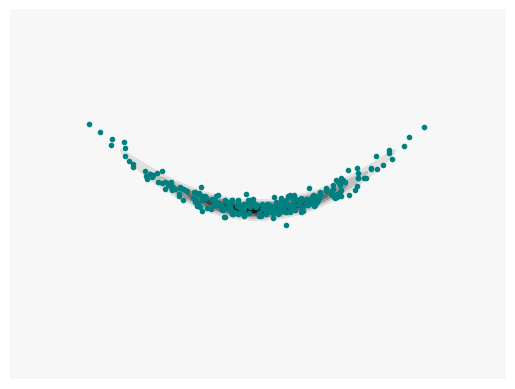

In [4]:
import matplotlib.pyplot as plt

x1 = jnp.linspace(-35, 35, 500)
x2 = jnp.linspace(-35, 35, 500)
X1, X2= jnp.meshgrid(x1, x2)
X = jnp.stack((X1, X2), axis=-1)
Z = jnp.exp(jax.vmap(jax.vmap(logdensity_fn))(X))

plt.plot(samples[:, 0], samples[:, 1], '.', color = 'teal')
plt.contourf(X1, X2, Z, cmap = 'Greys')
plt.axis('off')
plt.show()
